# Internet News Data

#### By: Dana Cassidy

## In this notebook, I'll be building both a reccomendation engine for news articles and also using NLP to predict trends in the news. I'll be doing both to gain a better understanding of how news is shared on the internet and which metrics -- such as engagement, post times, and more -- play a role into publication. 

### * I'll also offer explanatory analysis to better contextualize the data and draw conclusions from there, based on both the statistics and my experience as a journalist working in professional newsrooms. *

## Data can be found [here](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement).

## Outline:
### * 1) Prepping the data
### * 2) Reccomendation engine using Kmeans and TF-IDF
### * 3) EDA on trends and metrics
### * 4) Predicting using NLP



In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/internet-articles-data-with-users-engagement/articles_data.csv


## Let's begin by importing the data:

In [4]:
df = pd.read_csv('../input/internet-articles-data-with-users-engagement/articles_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


Upon examining our data, we can see that there are standard metrics for examining what the content actually is, such as sources, authors, titles, a description of the piece, urls, and date of publication. We can also see that there are columns that determine if it is a top article, the count of engagement reactions, comments, shares, and plugins. This will all be useful in our analysis and predictions.

## Preparing our data

In [6]:
df['title'] = df['title'].fillna('NaN')
df['description'] = df['description'].fillna('NaN')
df['content'] = df['content'].fillna('NaN')
df['published_at'] = df['published_at'].fillna('NaN')

df['engagement_reaction_count'] = df['engagement_reaction_count'].fillna(0)
df['engagement_comment_count'] = df['engagement_comment_count'].fillna(0)
df['engagement_share_count'] = df['engagement_share_count'].fillna(0)
df['engagement_comment_plugin_count'] = df['engagement_comment_plugin_count'].fillna(0)

Let's check our head again.

In [7]:
df.head()

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,0.0,0.0,0.0,0.0
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


Our data is much easier to use now.

In [8]:
print(df['source_id'].unique())
print(df['source_name'].unique())

['reuters' 'the-irish-times' 'al-jazeera-english' 'bbc-news' 'abc-news'
 'the-new-york-times' 'cnn' 'cbs-news' 'newsweek' 'business-insider'
 'the-wall-street-journal' 'espn' '1']
['Reuters' 'The Irish Times' 'Al Jazeera English' 'BBC News' 'ABC News'
 'The New York Times' 'CNN' 'CBS News' 'Newsweek' 'Business Insider'
 'The Wall Street Journal' 'ESPN' '460.0']


There are two columns, 'source_name' and 'source_id', which are almost identical. I'm also not sure why the value 460 is in there. Let's drop the row that contains the 460:

In [9]:
print(df[df['source_name']=="460.0"])
#Since its all full of NAN value we'll drop this useless row
df = df[df['source_name']!="460.0"]
print("Row Dropped")
df.shape

    source_id source_name author  title description  url url_to_image  \
750         1       460.0  151.0  352.0         0.0  NaN          NaN   

    published_at content  top_article  engagement_reaction_count  \
750          NaN     NaN          NaN                        0.0   

     engagement_comment_count  engagement_share_count  \
750                       0.0                     0.0   

     engagement_comment_plugin_count  
750                              0.0  
Row Dropped


(10436, 14)

In [10]:
df.isna().sum()

source_id                             0
source_name                           0
author                             1020
title                                 0
description                           0
url                                   0
url_to_image                        655
published_at                          0
content                               0
top_article                           1
engagement_reaction_count             0
engagement_comment_count              0
engagement_share_count                0
engagement_comment_plugin_count       0
dtype: int64

There seems to be about 24 or so rows without a description. Let's clean that up:

In [11]:
print(df[df['description'].isna()].isna().sum())
df = df[~df['title'].isna()]
df_2 = df.copy()

source_id                          0.0
source_name                        0.0
author                             0.0
title                              0.0
description                        0.0
url                                0.0
url_to_image                       0.0
published_at                       0.0
content                            0.0
top_article                        0.0
engagement_reaction_count          0.0
engagement_comment_count           0.0
engagement_share_count             0.0
engagement_comment_plugin_count    0.0
dtype: float64


We will be dropping the 18 without contents because we're not really able to improve or fix them since we aren't sure what the contents of the article entirely is.

In [12]:
df = df_2.copy()
empty_desc = df[df['description'].isna()]
df = df[~df['description'].isna()]
empty_desc = empty_desc[~empty_desc['content'].isna()]
df = pd.concat([df,empty_desc],axis=0)
df.isna().sum()

source_id                             0
source_name                           0
author                             1020
title                                 0
description                           0
url                                   0
url_to_image                        655
published_at                          0
content                               0
top_article                           1
engagement_reaction_count             0
engagement_comment_count              0
engagement_share_count                0
engagement_comment_plugin_count       0
dtype: int64

## Now, let's use KMeans via TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer #The Vector creator
from sklearn.metrics.pairwise import linear_kernel #Cosine similarity
from sklearn.cluster import MiniBatchKMeans #Kmeans Clustering Batch

In [14]:
cluster_the_content = df['description']
vector = TfidfVectorizer(max_df=0.5,min_df=1,stop_words="english",lowercase=True,use_idf=True,norm=u'l2',smooth_idf=True)
tfidf = vector.fit_transform(cluster_the_content)

In [15]:
k = 200
kmeans = MiniBatchKMeans(n_clusters= k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

### Let's add our descriptions to predict their classes:

In [16]:
request_transform = vector.transform(df['description'])
df['cluster'] = kmeans.predict(request_transform)
df['cluster'].value_counts().head()

81    8942
82     408
87     178
46     154
76      89
Name: cluster, dtype: int64

In [17]:
df.head()

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,cluster
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0,81
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0,81
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,0.0,0.0,0.0,0.0,81
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0,81
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0,81


#### Let's find the similarity between the documents:

In [18]:
def find_similar(matrix,index,top_n=5):
    cosine_similarities = linear_kernel(matrix[index:index+1],matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

## Graphing

Edges are :
* Wrote : relation between title and person
* CAT : Relation between title and Press
* Description : Relation between cluster and a movie
* Similarity in sense of description

In [19]:
import networkx as nx 
import time

G = nx.Graph(label="Article")
start_time = time.time()
for i,rowi in df.iterrows() :
    if (i > 3000) :
        continue
    if (i%1000 == 0) : 
        print("Iter  {} --- {} secondes --".format(i,time.time()-start_time))
    G.add_node(rowi['title'],key=i,label="Article")
    G.add_node(rowi['author'],label="Person")
    G.add_edge(rowi['title'],rowi['author'],label="Wrote")
    G.add_node(rowi['source_name'],label="Press")
    G.add_edge(rowi['title'],rowi['source_name'],label="CAT")
    #Similarity Node :
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].iloc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))   

Iter  0 --- 0.009904623031616211 secondes --
Iter  1000 --- 12.041131496429443 secondes --
Iter  2000 --- 24.00512719154358 secondes --
Iter  3000 --- 36.07732605934143 secondes --
 finish -- 36.663942098617554 seconds --


In [20]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)

In [21]:
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="Article":
            colors.append('blue')
        elif G.nodes[e]['label']=="Person":
            colors.append('red')
        elif G.nodes[e]['label']=="Press":
            colors.append('green')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('yellow')
    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

## Examining our graph with two examples to visualize:

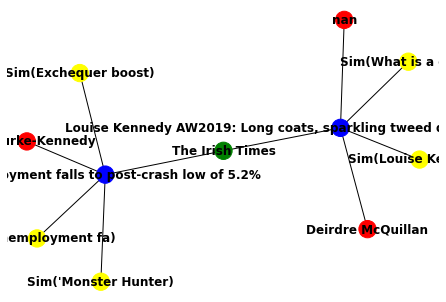

In [22]:
list_in=[df['title'].loc[1],df['title'].loc[2]]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)


### The next function is going to grab the neighbors nodes within our graph and then compute the weight. We are then going to sort the neighbors by a weight value:

In [23]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            try :
                if G.nodes[e2]['label']=="Article":
                    commons = commons_dict.get(e2)
                    if commons==None:
                        commons_dict.update({e2 : [e]})
                    else:
                        commons.append(e)
                        commons_dict.update({e2 : commons})
            except :
                pass
    articles=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        articles.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=articles)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [24]:
import math 

result = get_recommendation(df['title'].loc[40])
print("*"*40+"\n Recommendation for :"+str(df['title'].loc[40])+"\n"+"*"*40)
print(result.head())

****************************************
 Recommendation for :Pence defends decision to stay at Trump Doonbeg property
****************************************
House Democrats launch probe into Pence's stay at Trump's Doonbeg resort                                      2.295667
Mike Pence defends staying at Trump property in Doonbeg, Ireland                                              1.855313
Democrats seek documents on Pence's stay at Trump Ireland property and proposal to host G7 at Miami resort    1.674332
Pence faces row over stay at Trump Irish resort...                                                            1.179446
Pence Staying at Trump Property in Ireland at Trump’s ‘Suggestion,’ Aide Says                                 1.116221
dtype: float64


## Analyzing and understanding

#### Our model was able to find a reccomendation and compare it with other articles based on the selected article at hand. For the content titled 'Pence defends decision to stay at Trump Doonbeg property', we can see other articles reccomended below it that are similar to the category and topic of the reccommended piece. This is the heart of how reccomendation algorithms work.

Let's do some further visual analysis on our data:

In [25]:
def bar_charts(title, x, y, colour, values, keys, figsize=(10, 5), fontsize=12):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bars = plt.bar(keys, values, color=colour)

    for bar in bars:
        label = list(count)[list(bars).index(bar)]
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, label, ha='center', va='bottom', 
                 fontsize=fontsize)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(x, fontsize=fontsize)
    plt.ylabel(y, fontsize=fontsize)
    plt.show()

In [26]:
 def plots(title, x, y, values, keys, figsize=(10, 5), fontsize=12):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plt.plot(list(keys), list(values))
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

I just made some functions for plotting both bar and line graphs, respectively. Let's see how our charts look:

The first variable we displayed is the "source_name" column, which is the origin of where the article is published. 

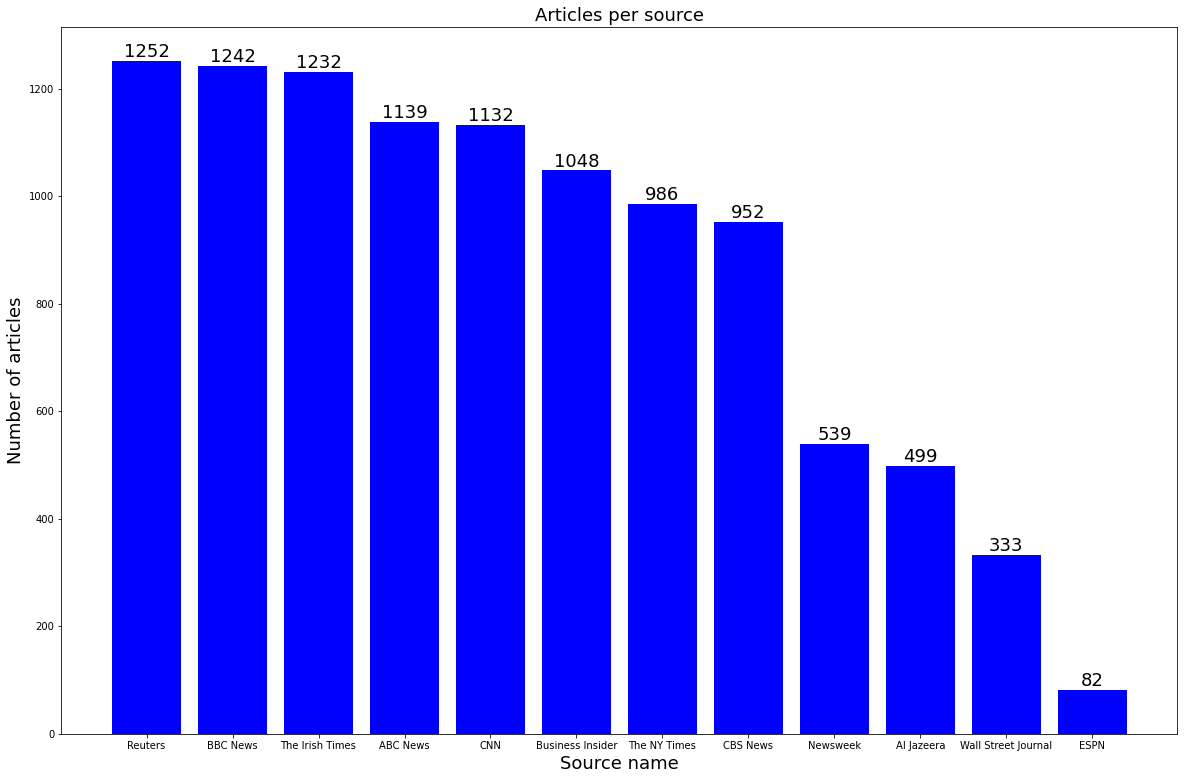

In [27]:
count = Counter(df['source_name'])
count = pd.Series(count).sort_values(ascending=False)

keys = list(count.keys())
keys[keys.index('The New York Times')] =  'The NY Times'
keys[keys.index('Al Jazeera English')] = 'Al Jazeera'
keys[keys.index('The Wall Street Journal')] =  'Wall Street Journal'

bar_charts('Articles per source', 'Source name', 'Number of articles', 'blue', count, keys,
          (20, 13), 18)

It looks like "Reuters", "BBC News", and "The Irish Times" all have the most artices.

We can also show the distribution of how many articles were written throughout the year. We can select different timeframes:

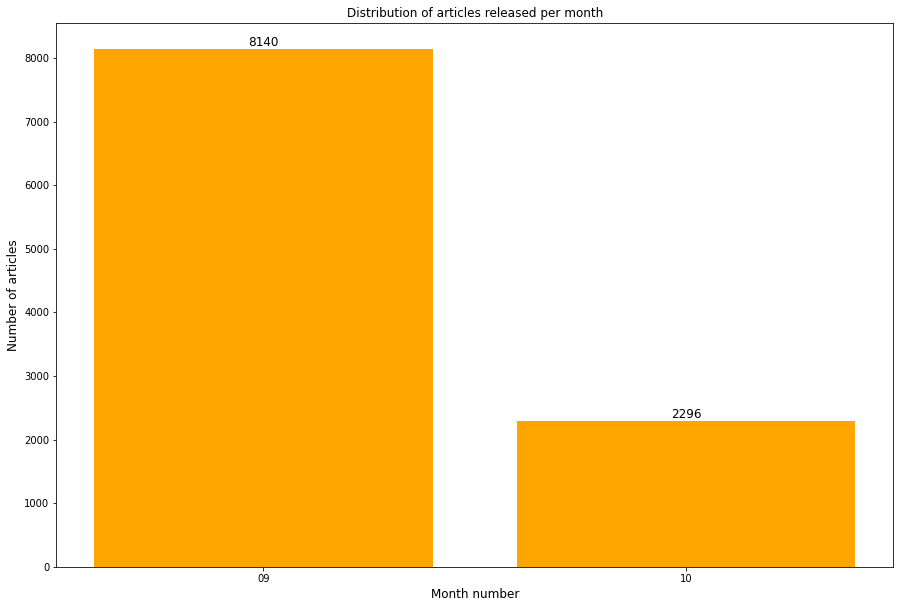

In [28]:
month = [i[5:7] for i in df['published_at']]
count = Counter(month)
count = pd.Series(count).sort_values(ascending=False)[:2]

bar_charts('Distribution of articles released per month', 'Month number', 'Number of articles',
          'orange', count, count.keys(), figsize=(15, 10))

We can do the same for days:

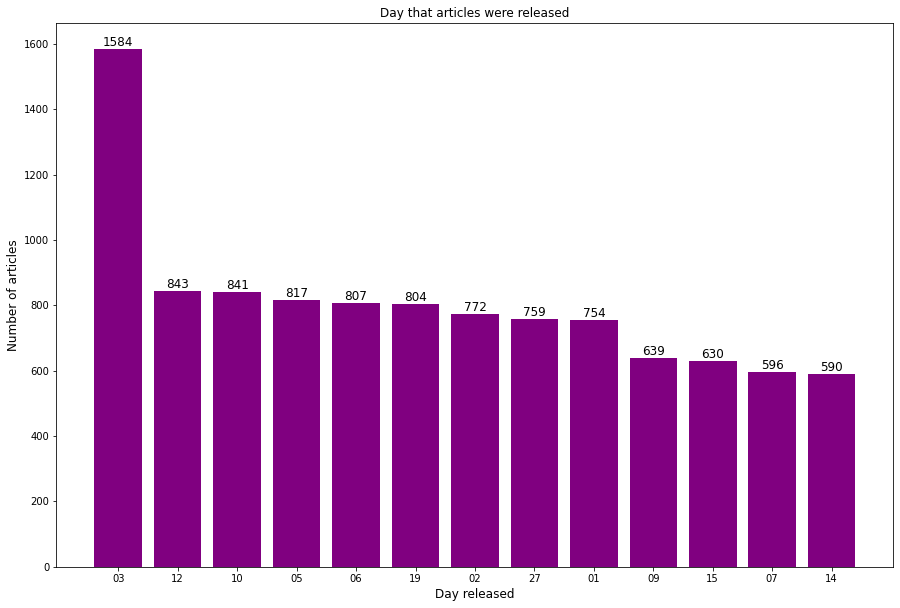

In [29]:
day = [i[8:10] for i in df['published_at']]
count = Counter(day)
count = pd.Series(count).sort_values(ascending=False)[:13]

bar_charts('Day that articles were released', 'Day released', 'Number of articles', 'purple', 
           count, count.keys(), figsize=(15, 10))

It's interesting to see how "03" was the most popular day of release. Journalistically, I am not sure why. Perhaps it's because a lot of news events happen on certain days of the third, like the U.S. presidential election. This doesn't explain why for every month, though.

Let's take it even further and look at the hours in terms of which are the most popular for publishing news articles.

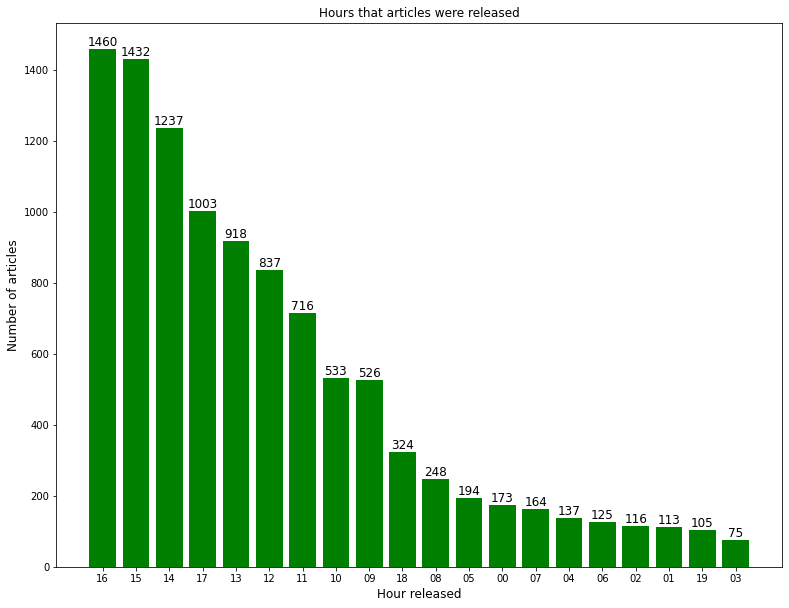

In [30]:
hour = [i[11:13] for i in df['published_at']]
count = Counter(hour)
count = pd.Series(count).sort_values(ascending=False)[:20]

bar_charts('Hours that articles were released', 'Hour released', 'Number of articles',
          'green', count, count.keys(), figsize=(13, 10))

A lot of articles seem to be primarily published between 2-4 p.m. This is fascinating because in newsrooms a lot of bigger feature pieces are published at the beginning of a work day, around 9 a.m., so people have time to read it during the day. It also, however, makes sense the the most *popular* upload time overall is the afternoon because breaking news typically happens in the morning and then articles follow it soon after. Meetings and other events can happen during the day, with correpsonding news about such events.

We can also conduct analysis on line graphs to see how many articles were released:

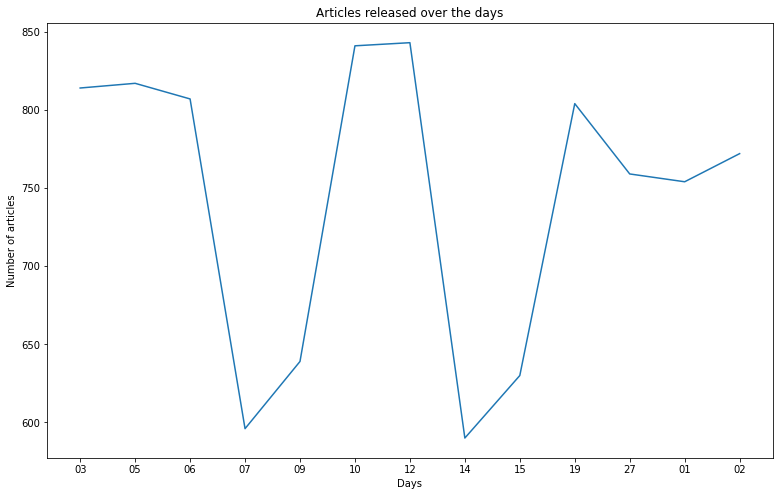

In [31]:
day_and_month = pd.DataFrame([])
day_and_month['day'] = day
day_and_month['month'] = month

count1 = Counter(day_and_month[day_and_month['month']=='09']['day'])
count2 = Counter(day_and_month[day_and_month['month']=='10']['day'])

keys = pd.concat([pd.Series(count1.keys()), pd.Series(count2.keys())[:2]])
values = pd.concat([pd.Series(count1.values()), pd.Series(count2.values())[:2]])
count = dict(zip(keys, values))

plots('Articles released over the days', 'Days', 'Number of articles', count.values(),
      count.keys(), (13, 8))

# Analyzing Engagement 

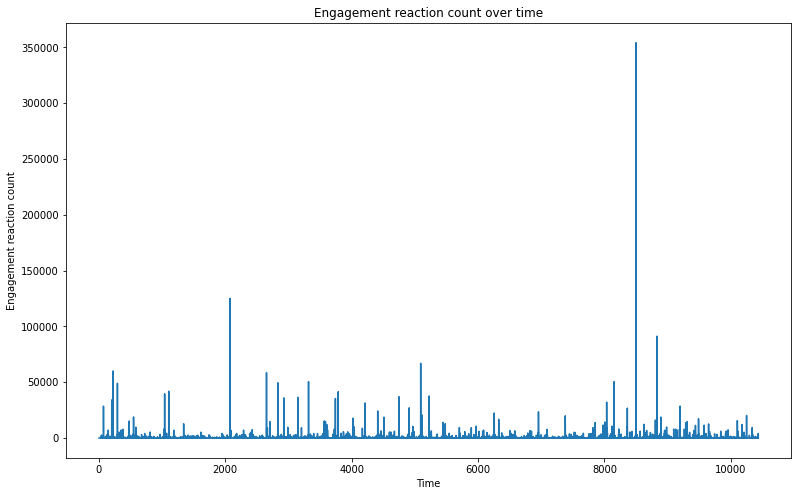

In [32]:
plots('Engagement reaction count over time', 'Time', 'Engagement reaction count', 
      df['engagement_reaction_count'], df['engagement_reaction_count'].keys(), (13, 8))

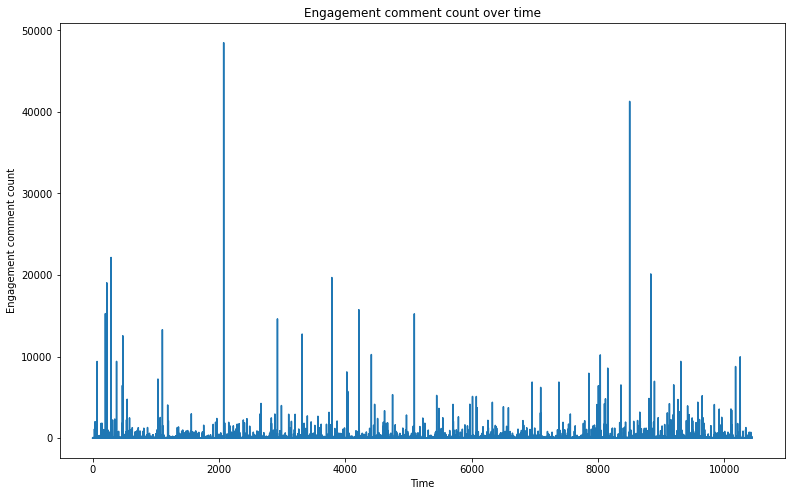

In [33]:
plots('Engagement comment count over time', 'Time', 'Engagement comment count', 
      df['engagement_comment_count'], df['engagement_comment_count'].keys(), (13, 8))

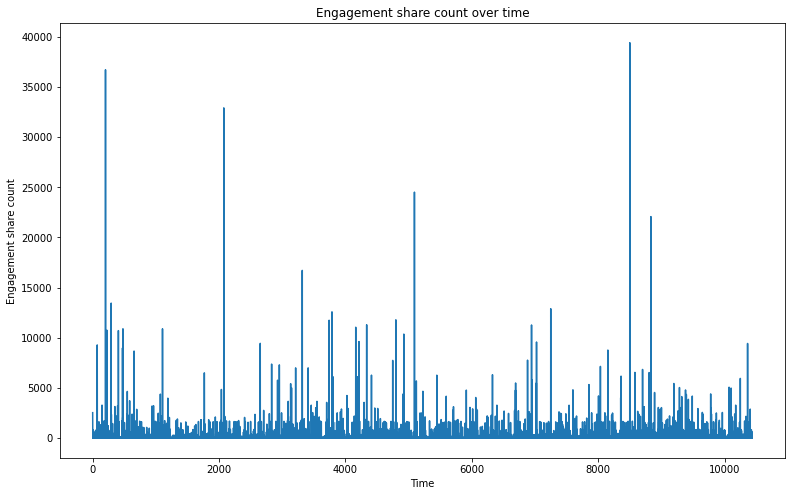

In [34]:
plots('Engagement share count over time', 'Time', 'Engagement share count', 
      df['engagement_share_count'], df['engagement_share_count'].keys(), (13, 8))

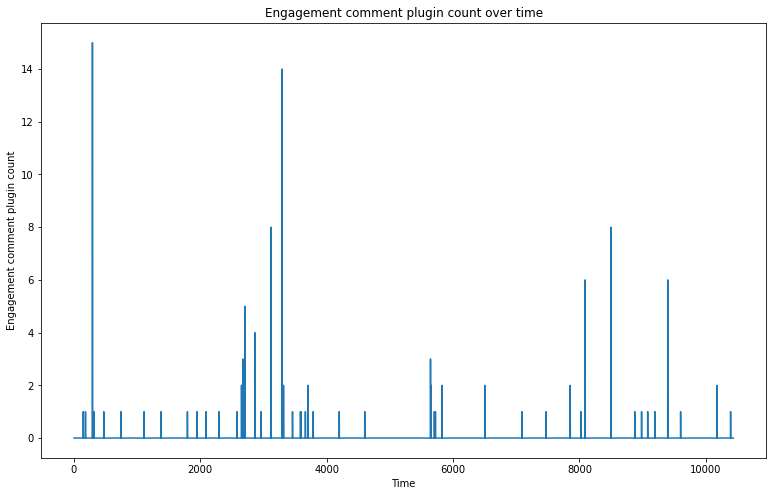

In [35]:
plots('Engagement comment plugin count over time', 'Time', 'Engagement comment plugin count', 
      df['engagement_comment_plugin_count'], df['engagement_comment_plugin_count'].keys(), 
      (13, 8))

## Correlations

I'm going to use a heatmap to examine whether or not there are correlations between any of the variables. There are three different types of features that have a connection, so there likely is a dependency on one another:

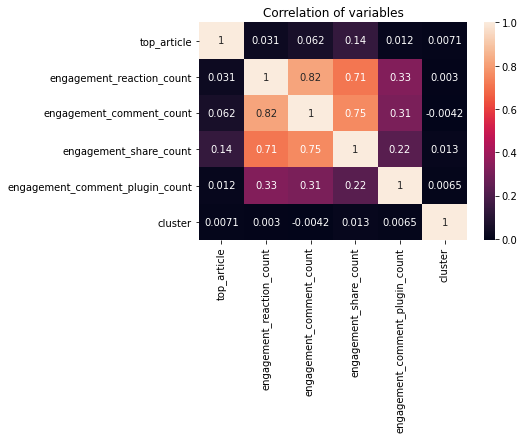

In [36]:
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation of variables')
plt.show()

Let's scatter the datapoints and create a line that best fit to see how the different variables correlate to one another. Let's all remove some of the outliers in the columns because they could skew our results:

In [37]:
df['engagement_reaction_count'] = df['engagement_reaction_count'][df['engagement_reaction_count']<100000]
df['engagement_share_count'] = df['engagement_share_count'][df['engagement_share_count']<20000]

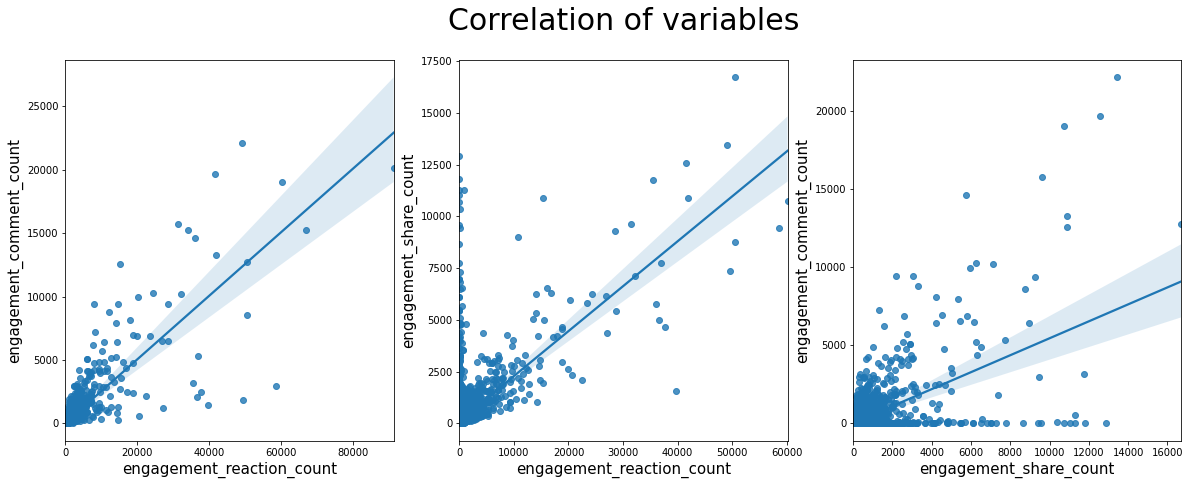

In [38]:
fontsize=15
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

for ax in [[ax1, ['engagement_reaction_count', 'engagement_comment_count']],
           [ax2, ['engagement_reaction_count', 'engagement_share_count']],
           [ax3, ['engagement_share_count', 'engagement_comment_count']]]:
    sns.regplot(data=df, x=ax[1][0], y=ax[1][1], ax=ax[0])
    ax[0].set_xlabel(ax[1][0], fontsize=fontsize)
    ax[0].set_ylabel(ax[1][1], fontsize=fontsize)

ax2.set_title('Correlation of variables', fontsize=30, pad=30)
plt.show()

# Predicting the data (pt. 2)

## Let's split up our dataset:

We can assign 'X" to our 'content' feature and 'y' to our 'source_name' feature, which we can further split into our train and test sets 

In [39]:
X = df['content']
y = df['source_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## NLP

Let's convert our data from textual into numerical format to input it into a predictor. We can do so using "CountVectorizer" and a "TFIDF" model.

In [40]:
cv = CountVectorizer()
tfidf = TfidfTransformer()

X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Using TruncatedSVD

We can reduce the unwanted parts of the data through a TruncatedSVD model, which essentially is a PCA for our text:

In [41]:
svd = TruncatedSVD(n_components=2000)
X_train = svd.fit_transform(X_train)
X_test = svd.transform(X_test)

## Let's create and evaluate our classifiers: 'SGD', 'Random Forest', and 'Linear SVC'.

In [42]:
classifiers = [['SGD', SGDClassifier()], ['Random Forest', RandomForestClassifier()],
              ['Linear SVC', LinearSVC()]]
scores = []
cross_vals = []

for classifier in classifiers:
    model = classifier[1]
    model.fit(X_train, y_train)

    score = model.score(X_test, y_test)
    cross_val = cross_val_score(model, X_test, y_test).mean()
    scores.append(score)
    cross_vals.append(cross_val)
    
    print(classifier[0])
    print(score)
    print(cross_val)
    if model != classifiers[-1][1]:
        print('')

SGD
0.6355363984674329
0.5526797700595504

Random Forest
0.44157088122605365
0.3170516218604064

Linear SVC
0.6590038314176245
0.5713630052895483


Lastly, let's use bar charts to visualize how well each classifier did in relation to a model score and cross val score.

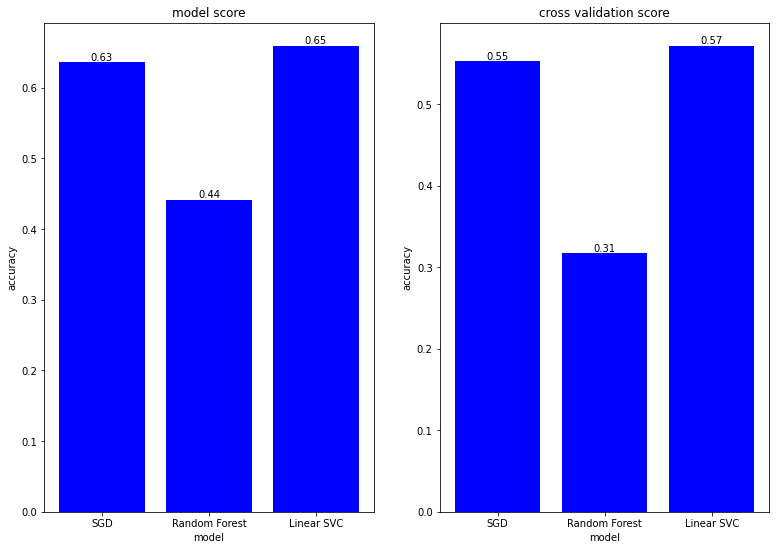

In [43]:
names = ['SGD', 'Random Forest', 'Linear SVC']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 9))

for ax in [[ax1, scores, 'model score'], [ax2, cross_vals, 'cross validation score']]:
    metric = ax[1]
    bars = ax[0].bar(names, metric, color='blue')
    for bar in bars:
        label = str(metric[list(bars).index(bar)])[:4]
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width()/2, height, label, ha='center', va='bottom')
    ax[0].set_title(ax[2])
    ax[0].set_xlabel('model')
    ax[0].set_ylabel('accuracy')

plt.show()

LinearSVC did the best out of all of our classifiers.

# Conclusion

### This notebook created a reccomendation engine and used EDA and NLP to examine and predict trends in our data about internet news.